In [12]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
from tqdm import tqdm

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.1 GB
Cached:    4.1 GB


In [13]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Set the paths for the datasets
base_folder = "../datasets/Vision_data"
train_folder = os.path.join(base_folder, "train")
test_folder = os.path.join(base_folder, "test")
validation_folder = os.path.join(base_folder, "validation")

# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batchsize = 64
numworkers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)

In [14]:
output_folder = "../output/"
# Load and modify the pretrained InceptionV1 model
model = models.googlenet(weights=models.Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
def warmup_cosine_annealing(lr, warmup_epochs, total_epochs, warmup_start_lr=1e-5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (lr - warmup_start_lr) / warmup_epochs * epoch + warmup_start_lr / lr
        elif total_epochs > warmup_epochs:
            return 0.5 * (1 + torch.cos(torch.tensor(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs))))
        else:
            return 1
    return lr_lambda

num_epochs = 20
scheduler = LambdaLR(optimizer, lr_lambda=warmup_cosine_annealing(0.001, 5, num_epochs))

# TensorBoard setup
writer = SummaryWriter('../runs/inceptionv1_experiment')

# Initialize a DataFrame to store epoch, training loss, validation accuracy, and test accuracy
df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Validation Accuracy', 'Test Accuracy', 'Epoch Duration'])
df = df.astype({'Epoch': 'int32', 'Training Loss': 'float64', 'Validation Accuracy': 'float64', 'Test Accuracy': 'float64', 'Epoch Duration': 'float64'})

# Initialize best validation accuracy
best_val_accuracy = 0

# Training loop with model checkpointing and TensorBoard logging
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    
    # Test Phase
    model.eval()
    total_test = 0
    correct_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)

    # Validation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = correct / total
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    epoch_duration = time.time() - start_time
    
    # Add data to DataFrame
    new_row = pd.DataFrame({
        'Epoch': [epoch + 1], 
        'Training Loss': [avg_train_loss], 
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy],
        'Epoch Duration': [epoch_duration]
    })
    df = pd.concat([df, new_row], ignore_index=True)

    # Checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(output_folder, f'inceptionv1_epoch{epoch}.pth'))

    scheduler.step()

writer.close()

# Save the DataFrame to a CSV file with a timestamp
output_folder = "../output/"
os.makedirs(output_folder, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"inceptionv1_training_results_{timestamp}.csv"
df.to_csv(os.path.join(output_folder, csv_filename), index=False)


Epoch 20/20: 100%|██████████| 379/379 [06:26<00:00,  1.02s/it]


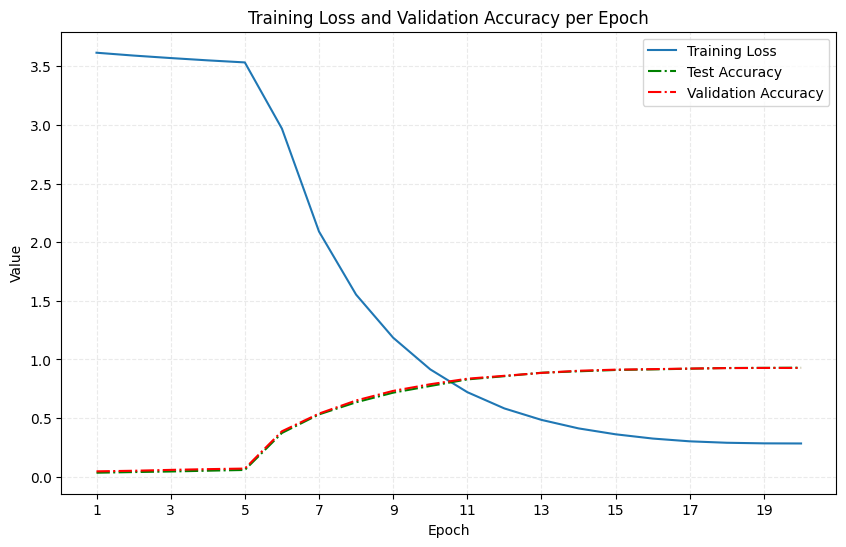

In [15]:
import matplotlib.pyplot as plt

# Plotting the training loss and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], linestyle='-', label='Training Loss')
plt.plot(df['Epoch'], df['Test Accuracy'], linestyle='-.', color='green', label='Test Accuracy')
plt.plot(df['Epoch'], df['Validation Accuracy'], linestyle='-.', color='red', label='Validation Accuracy')
plt.title('Training Loss and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(1, num_epochs + 1, 2))  # Set x-axis ticks to be every 2 epochs
plt.grid(True, which='both', axis='both', linestyle='--', color="#eaeaea")
plt.legend()
plt.savefig(os.path.join(output_folder, f"training_plot_{timestamp}.png"), dpi=300)  # Save the plot as a PNG file
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def get_all_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels

# Get predictions and true labels for both datasets
train_preds, train_labels = get_all_predictions(train_loader, model, device)
val_preds, val_labels = get_all_predictions(validation_loader, model, device)

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15), dpi=300)

ConfusionMatrixDisplay(train_cm, display_labels=train_dataset.classes).plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xticklabels(rotation=45, labels=train_dataset.classes, ha= 'right')

ConfusionMatrixDisplay(val_cm, display_labels=validation_dataset.classes).plot(ax=axes[1], cmap=plt.cm.Reds)
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xticklabels(rotation=45, labels=validation_dataset.classes, ha='right')

plt.show()

In [ ]:
import torch
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(validation_dataset)), 10)
images, true_labels = zip(*[validation_dataset[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = validation_dataset.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {validation_dataset.classes[true_label]}')
    plt.axis('off')
plt.show()
plt.savefig('../output/sample_predictions_ResNet18.jpg', dpi=300, bbox_inches='tight', pad_inches=0)